**CSCI 5622-001**
# Homework 5 - Report

Team 4: Leo Beck, Eric Fithian, Indu Varshinin Jayapal, Naveena Ganesan

## Data Background and Preprocessing Steps:
The data provided was in separate CSV files for each participant, with each record representing the participant's turn and the corresponding features. The train folder contained 87 files, while the test folder had 20 files. To simplify the process, all CSVs from the train folder were combined into a single file. The participant ID was extracted from the CSV file name and added as a feature to the consolidated data. The "labels.csv" file was used to map the participant ID to their corresponding gender and depression labels. The test data underwent a similar treatment. As a result, two files were generated: "final_training_data" with 13,625 records and 91 columns, and "final_testing_data" with 3,280 records and 91 columns. In addition to the 88 audio features provided, three columns were added: "participant_id," "gender," and "depression".

In [43]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

In [44]:
def data_fetch(file_path):
    '''
    Fetch the data and remove NAs
    
    Returns:
    1. Dataframe
    '''
    df = pd.read_csv(file_path, index_col=0)
    
    #After data exploring we found that one of the data sample's turn was all NA. So we removed it
    df.dropna(inplace=True)
    
    return df

def prep_X_y(df,target):
    '''
    Prepare X and y sets for the given dataframe and the specified target (Depression or Gender)
    Scales the features using Standard Scaler
    
    Returns:
    1. Scaled X as an array
    2. y as a Pandas series
    3. Gender values as a Pandas series
    4. Feature names from filtered X as a Pandas Index
    '''
        
    #Prepare X
    X = df.drop(['Depression', 'Gender', 'participant_id'], axis=1)
    
    #Get features for X set
    features = X.columns
    
    #Normalize X using standard scaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    #Prepare y
    y = df[target]
    
    #Get Gender flags
    gender = df['Gender']
    
    return X,y,gender,features

## (a.i) Depression classiﬁcation

In [45]:
def hyperparameter_tuning_rf(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000, 1200],  #Number of trees in the forest
        'max_features': ['sqrt', 'log2'],  #Number of features to consider at every split
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  #Maximum number of levels in tree
        'min_samples_split': [2, 5, 10]  #Minimum number of samples required to split a node
    }
    
    #Initialize the classifier
    rf = RandomForestClassifier(random_state=42)

    print("Initializing the evaluator")
    #Define cross-validation evaluation for the search space
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)  
    
    #Setup the random search space with repeated stratified k fold cross-validation
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=cv, 
                                     scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

    print("Fitting the random search cv on the training data")
    #Fit random_search to the data
    random_search.fit(X_train, y_train)

    #Best parameters
    best_params = random_search.best_params_
    print("Best parameters:", best_params)
    
    #Best model from random search
    best_rf = random_search.best_estimator_

    #Predict on the validation set
    y_pred = best_rf.predict(X_val)

    #Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", accuracy)
    
    return best_params

After experimenting with both Feed Forward Neural Network (FNN) and Random Forest Classifier (RF), we decided to model the Depression classification using Random Forest due to its ease of interpretability and faster processing speed. Although the FNN had a slight advantage in terms of accuracy, the Random Forest Classifier proved to be a more suitable choice for this particular task, offering a balance between performance and practicality. 

Moving forward with this choice, we used a Randomized Search CV to identify the best hyperparameters for the Random Forest Classifier. Our goal for this optimization was to reduce overfitting the model, so we chose hyperparameters that would help us attain this objective. We selected n_estimators, max_features, max_depth, and min_samples_split. Increasing the number of trees can help reduce overfitting by creating a more diverse ensemble. By limiting the number of features, the Random Forest is forced to focus on the most informative features and reduces the chances of overfitting to noise or irrelevant features. Limiting the depth of the trees helps in controlling their complexity and prevents them from growing too deep and overfitting to the training data. Increasing min_samples_split prevents the trees from splitting on very small subsets of data, which can be prone to overfitting. However, it is important to note that increasing or decreasing these hyperparameters beyond a certain point can be detrimental to the model's training process.

To find the best hyperparameters for our Random Forest Classifier, we employed the Repeated Stratified K Fold Cross Validation technique in conjunction with RandomizedSearchCV. This approach helps us avoid obtaining a noisy estimate of the model's performance, which can happen when different splits of the data lead to vastly different results. By using RepeatedStratifiedKFold, we can improve the estimated performance of our machine learning model through a simple yet effective method. The cross-validation procedure is repeated multiple times, and the mean result across all folds from all runs is reported. This mean result serves as a more accurate and reliable estimate of the model's true performance, as it takes into account the variability that can occur due to different data splits.

### Evaluation Functions

In [46]:
def aggregatePredictions(predictions, ids, genders):
    df = pd.DataFrame({'id': ids, 'prediction': predictions, 'gender': genders})
    df_aggregated = df.groupby('id').agg(
        prediction=('prediction', lambda x: np.round(x.mean()).astype(int)),
        gender=('gender', 'first')
    )
    return df_aggregated

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ba = 0.5 * (cm[0, 0] / cm[0,:].sum() + cm[1, 1] / cm[1,:].sum())
    return accuracy, ba

#Calculate equality of opportunity (EO) for the test set
def calculate_tpr(y_true_test, y_pred_test, genders_test, participant_ids_test):
    genders_test_aggregated = genders_test.groupby(participant_ids_test).first()
    male_mask_test = (genders_test_aggregated == 1)
    female_mask_test = (genders_test_aggregated == 0)
    tpr_male_test = accuracy_score(y_true_test[male_mask_test], y_pred_test[male_mask_test])
    tpr_female_test = accuracy_score(y_true_test[female_mask_test], y_pred_test[female_mask_test])
    
    return [male_mask_test, female_mask_test, tpr_male_test, tpr_female_test]

The below piece of code does the following: Gets the already preprocessed train and test datasets, removes NAs and generates train, validation and test sets for Depression Classification. Once we have the data prepped, it calls the hyperparameter tuning module for the random forest classifier. With the best model, predictions are made on the test set. Both the predicted values and the actual values are evaluated on accuracy, balanced accuracy and true positive rate on a participant level. Evaluation metrics are also given at male and female level. 

In [64]:
train_file = "../Datasets/ADS/final_training_data.csv"
test_file = "../Datasets/ADS/final_testing_data.csv"

train_data = data_fetch(train_file)
test_data = data_fetch(test_file)

#Model Pre-Training Steps
#Select the features, target variables, genders and feature names from the train dataset
print("Fetching data for Target Variable: Depression")
X_train_raw, y_train_raw, gender_train_raw, feature_names = prep_X_y(train_data, 'Depression')

print("Number of Features to train: ", len(feature_names))

#Split the data into training only and validation set
X_train, X_val, y_train, y_val, genders_train, genders_val = train_test_split(X_train_raw, 
                                                                              y_train_raw, 
                                                                              gender_train_raw, 
                                                                              test_size=0.2, 
                                                                              random_state=42)

#Select the features, target variables and genders from the test set
X_test, y_test, genders_test = prep_X_y(test_data, 'Depression')[0:3]

print("Shape of X train: ", X_train.shape, 
      "\nShape of X validation: ", X_val.shape, 
      "\nShape of X test: ", X_test.shape,
      "\nShape of y train: ", y_train.shape, 
      "\nShape of y validation: ", y_val.shape,
      "\nShape of y test: ", y_test.shape)

#Function call to the Hyperparameter tuning with Validation set module
#best_hps = hyperparameter_tuning_rf(X_train, y_train, X_val, y_val)
best_hps = {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50}
rf_best = RandomForestClassifier(max_depth = best_hps['max_depth'],
                              max_features = best_hps['max_features'], 
                              min_samples_split = best_hps['min_samples_split'],
                              n_estimators = best_hps['n_estimators'],
                              random_state=42)
print("Model with best parameters fitting on Train Data")
rf_best.fit(X_train, y_train)

print("Making Predictions on the Train Data")
#Make predictions on the test set
y_pred = rf_best.predict(X_test)

#Get the participant IDs for the test set
ids_test = test_data['participant_id'] 

#Aggregrate the predictions on Participant level
y_pred_aggregated = aggregatePredictions(y_pred, ids_test, genders_test)
y_test_aggregated = aggregatePredictions(y_test.values, ids_test, genders_test)

acc, ba = evaluate_metrics(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])

mask_and_tpr = calculate_tpr(y_test_aggregated['prediction'], y_pred_aggregated['prediction'], 
                              genders_test, ids_test)
male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0:4]
eo = 1 - abs(tpr_male_test - tpr_female_test)

#Print the evaluation metrics for the test set
print(f"Test Accuracy: {acc} ; Test Balanced Accuracy: {round(ba,3)}, Test Equality of Opportunity (EO):{round(eo,3)}")

male_ac, male_ba = evaluate_metrics(y_test_aggregated[male_mask_test]['prediction'], 
                                    y_pred_aggregated[male_mask_test]['prediction'])

female_ac, female_ba = evaluate_metrics(y_test_aggregated[female_mask_test]['prediction'],
                                          y_pred_aggregated[female_mask_test]['prediction'])
#Print the evaluation metrics for male and female participants separately
print(f"Male Accuracy: {round(male_ac,3)} ; Male Balanced Accuracy: {round(male_ba,3)}")
print(f"Female Accuracy: {round(female_ac,3)} ; Female Balanced Accuracy: {round(female_ba,3)}")

Fetching data for Target Variable: Depression
Number of Features to train:  88
Shape of X train:  (10900, 88) 
Shape of X validation:  (2725, 88) 
Shape of X test:  (3280, 88) 
Shape of y train:  (10900,) 
Shape of y validation:  (2725,) 
Shape of y test:  (3280,)
Model with best parameters fitting on Train Data
Making Predictions on the Train Data
Test Accuracy: 0.7 ; Test Balanced Accuracy: 0.5, Test Equality of Opportunity (EO):0.458
Male Accuracy: 0.917 ; Male Balanced Accuracy: 0.5
Female Accuracy: 0.375 ; Female Balanced Accuracy: 0.5


### Depression Classification - Results

The overall test accuracy of 0.7 indicates that the classifier correctly predicts the presence or absence of depression in 70% of the test samples. However, the balanced accuracy of 0.5 suggests that the classifier's performance is not consistent across the two classes (depression and no depression). A balanced accuracy of 0.5 is equivalent to random guessing, implying that the classifier is not effectively distinguishing between the two classes. One possible reason for this could be that the model is overfitting. We see our validation accuracy to be around 84%, while our prediction accuracy is only 70%, indicating that the model might be overfitting on the train data.

When we look at the gender-specific results, we see a significant disparity between male and female accuracy. The classifier achieves a high accuracy of 0.917 for male participants, meaning it correctly identifies the presence or absence of depression in 91.7% of the male test samples. In contrast, the accuracy for female participants is only 0.375, indicating that the classifier correctly identifies depression in only 37.5% of the female test samples. The balanced accuracy for both male and female participants is 0.5, which aligns with the overall balanced accuracy.

The Equality of Opportunity (EO) value of 0.458 quantifies the difference in true positive rates between male and female participants. An EO value closer to 1 indicates a smaller difference in true positive rates, while a value closer to 0 indicates a larger difference. In this case, the EO value of 0.458 suggests a substantial difference in the classifier's ability to correctly identify depression in males versus females.

These findings raise concerns about the fairness and bias of the depression classification model. The model appears to be significantly better at identifying depression in male participants compared to female participants.

## (b) Finding the most informative features for depression

To find the most informative features, we use [Mutual information (MI)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) as our filter feature selection method. MI measures the dependency between two random variables. It gives out values on a scale starting from 0, indicating no dependency. Higher values of MI indicate higher dependency.

In [61]:
info = mutual_info_classif(X_train, y_train)
features_ranked = feature_names[np.argsort(-info)]

In [62]:
selected_features = features_ranked[:20]
print(selected_features)

Index(['loudness_sma3_pctlrange0-2', 'equivalentSoundLevel_dBp',
       'loudness_sma3_percentile80.0', 'loudness_sma3_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'spectralFluxV_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'loudness_sma3_meanFallingSlope', 'loudness_sma3_meanRisingSlope',
       'mfcc2_sma3_stddevNorm', 'loudness_sma3_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_amean', 'slopeV500-1500_sma3nz_stddevNorm',
       'spectralFlux_sma3_amean', 'F2frequency_sma3nz_amean',
       'mfcc3V_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean',
       'shimmerLocaldB_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_amean'],
      dtype='object')


Mutual information is calculated to determine the importance of each feature regarding the target variable. The above listed features are the most 20 informative features of depression on the training data. Among all the features most of them are loudness related and F0semitone related features.

In the code below, we will iterate through different numbers of features out of the 88 features we have. We will retrain our best depression classification model and evaluate the test set in each case.

In [66]:
#Evaluation over different numbers of top features
n_features = [10, 15, 20, 25, 30, 35, 40, 45, 50, 88]
results = []

for n in n_features:
    selected_features = features_ranked[:n]
    selected_feature_indices = [feature_names.get_loc(name) for name in selected_features]
    rf_best.fit(X_train[:, selected_feature_indices], y_train)
    y_pred = rf_best.predict(X_test[:, selected_feature_indices])

    y_pred_aggregated = aggregatePredictions(y_pred, ids_test, genders_test)
    y_test_aggregated = aggregatePredictions(y_test.values, ids_test, genders_test)

    acc, ba = evaluate_metrics(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])

    mask_and_tpr = calculate_tpr(y_test_aggregated['prediction'], y_pred_aggregated['prediction'],
                                 genders_test, ids_test)
    male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
    eo = 1 - abs(tpr_male_test - tpr_female_test)

    print(f"No of features: {n} ; acc: {acc} ; ba: {round(ba,3)}, eo:{round(eo,3)}")
    results.append((n, acc, round(ba,3), round(eo,3)))

No of features: 10 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 15 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 20 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 25 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 30 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 35 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 40 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 45 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 50 ; acc: 0.7 ; ba: 0.5, eo:0.458
No of features: 88 ; acc: 0.7 ; ba: 0.5, eo:0.458



The accuracies are evaluated based on the different number of selected features. It shows that with 10,15 features accuracy, balanced accuracy is lowest and EO is highest. For all the other different number of features, the accuracy, balanced accuracy and EO is the same. The accuracy improves from 0.65 to 0.7 as the number of features increases from 15 to 20. This suggests that the additional five features included between these two points provide meaningful information that enhances the model’s predictive capabilities. The extra features beyond the first 20 do not contribute additional predictive value. Let's visualize how the performance shifts with increasing the features.

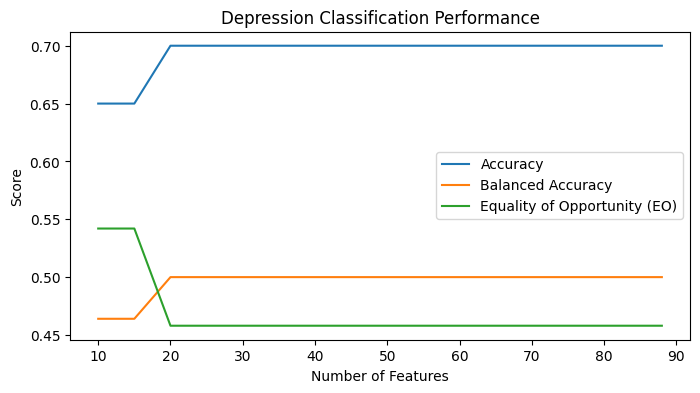

In [70]:
# Plotting the results
results = np.array(results)
plt.figure(figsize=(8, 4))
plt.plot(results[:, 0], results[:, 1], label='Accuracy')
plt.plot(results[:, 0], results[:, 2], label='Balanced Accuracy')
plt.plot(results[:, 0], results[:, 3], label='Equality of Opportunity (EO)')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Depression Classification Performance')
plt.legend()
plt.show()

## (a.ii) Gender Classification

From our experimentation for Gender classification with Feed Forward Neural Network and random forest classifier, Feed Forward Neural Network produced better results in terms of accuracy. Since we are not looking much into interpretability in terms of gender classification, we decided to move forward with feed forward neural network for our final modeling.

In [ ]:
from keras import models, layers, optimizers, regularizers

def build_and_train_model(layer_sizes, activation_fn, regularization_rate, X_train, y_train, X_val, y_val):
    model = models.Sequential()
    for i, size in enumerate(layer_sizes):
        if i == 0:
            model.add(layers.Dense(size, activation=activation_fn, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(regularization_rate)))
        else:
            model.add(layers.Dense(size, activation=activation_fn, kernel_regularizer=regularizers.l2(regularization_rate)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    if X_val is not None and y_val is not None:
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print('Validation Accuracy:', accuracy)
        
    return model

model1 = build_and_train_model([256, 64, 32], 'relu', 0.001, X_train, y_train, X_val, y_val)
model2 = build_and_train_model([256, 64, 32], 'sigmoid', 0.001, X_train, y_train, X_val, y_val)
model3 = build_and_train_model([256, 128, 64, 32], 'relu', 0.001, X_train, y_train, X_val, y_val)
model4 = build_and_train_model([512, 256, 128, 32], 'relu', 0.001, X_train, y_train, X_val, y_val)


In [ ]:
#Select the features, target variables for Gender Classification
print("Fetching data for Target Variable: Gender")
X_train_raw, y_train_raw, gender_train_raw, feature_names = prep_X_y(train_data, 'Gender')

print("Number of Features to train: ", len(feature_names))

#Split the data into training only and validation set
X_train, X_val, y_train, y_val, genders_train, genders_val = train_test_split(X_train_raw, 
                                                                              y_train_raw, 
                                                                              gender_train_raw, 
                                                                              test_size=0.2, 
                                                                              random_state=42)

#Select the features, target variables and genders from the test set
X_test, y_test, genders_test = prep_X_y(test_data, 'Depression')[0:3]

print("Shape of X train: ", X_train.shape, 
      "\nShape of X validation: ", X_val.shape, 
      "\nShape of X test: ", X_test.shape,
      "\nShape of y train: ", y_train.shape, 
      "\nShape of y validation: ", y_val.shape,
      "\nShape of y test: ", y_test.shape)

#Function call to the Hyperparameter tuning with Validation set module
#best_hps = hyperparameter_tuning_rf(X_train, y_train, X_val, y_val)
best_hps = {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50}
rf_best = RandomForestClassifier(max_depth = best_hps['max_depth'],
                              max_features = best_hps['max_features'], 
                              min_samples_split = best_hps['min_samples_split'],
                              n_estimators = best_hps['n_estimators'],
                              random_state=42)
print("Model with best parameters fitting on Train Data")
rf_best.fit(X_train, y_train)

print("Making Predictions on the Train Data")
#Make predictions on the test set
y_pred = rf_best.predict(X_test)

#Get the participant IDs for the test set
ids_test = test_data['participant_id'] 

#Aggregrate the predictions on Participant level
y_pred_aggregated = aggregatePredictions(y_pred, ids_test, genders_test)
y_test_aggregated = aggregatePredictions(y_test.values, ids_test, genders_test)

acc, ba = evaluate_metrics(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])

mask_and_tpr = calculate_tpr(y_test_aggregated['prediction'], y_pred_aggregated['prediction'], 
                              genders_test, ids_test)
male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0:4]
eo = 1 - abs(tpr_male_test - tpr_female_test)

#Print the evaluation metrics for the test set
print(f"Test Accuracy: {acc} ; Test Balanced Accuracy: {round(ba,3)}, Test Equality of Opportunity (EO):{round(eo,3)}")

male_ac, male_ba = evaluate_metrics(y_test_aggregated[male_mask_test]['prediction'], 
                                    y_pred_aggregated[male_mask_test]['prediction'])

female_ac, female_ba = evaluate_metrics(y_test_aggregated[female_mask_test]['prediction'],
                                          y_pred_aggregated[female_mask_test]['prediction'])
#Print the evaluation metrics for male and female participants separately
print(f"Male Accuracy: {round(male_ac,3)} ; Male Balanced Accuracy: {round(male_ba,3)}")
print(f"Female Accuracy: {round(female_ac,3)} ; Female Balanced Accuracy: {round(female_ba,3)}")

## (c) Finding the most informative features for gender.

To find the most informative features for gender, we fit a random forest classfier and used the importance value from the results of this model as our filter feature selection method.

## (d) Mitigating bias via removing gender-dependent features.

## (e) Mitigating bias via other approaches. (re-weighting the samples)

In [71]:
def calculate_weights(y):
    #Calculate the weights inversely proportional to class frequencies
    class_weights = y.value_counts(normalize=True)
    print(f"Class weights: {class_weights}")
    weights = 1.0 / class_weights
    print(f"Weights: {weights}")
    normalized_weights = len(y) * weights / weights.sum()
    print(f"Normalized weights: {normalized_weights}")
    return normalized_weights

In [72]:
gender_weights = calculate_weights(genders_train)
sample_weights = genders_train.map(gender_weights)
print(sample_weights.shape)

Class weights: Gender
1    0.602752
0    0.397248
Name: proportion, dtype: float64
Weights: Gender
1    1.659056
0    2.517321
Name: proportion, dtype: float64
Normalized weights: Gender
1    4330.0
0    6570.0
Name: proportion, dtype: float64
(10900,)


Weights are re-calculated for the gender to mitigate the bias. Weights calculation is based on the inverse proportion to the class frequencies. This weights for the gender are used to train and evaluate the model.

In [76]:
#Training a Random Forest Classifier with best hyperparameters from a(i)
rf_bias_sw = RandomForestClassifier(max_depth = best_hps['max_depth'],
                              max_features = best_hps['max_features'], 
                              min_samples_split = best_hps['min_samples_split'],
                              n_estimators = best_hps['n_estimators'],
                              random_state=42)

#Adding weights while training the model
rf_bias_sw.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_bias_sw = rf_bias_sw.predict(X_test)

In [79]:
#Evaluate the predictions on accuracy, balanced accuracy and EO on a participant and male and female level

#Aggregrate the predictions on Participant level
y_pred_bias_sw_aggregated = aggregatePredictions(y_pred_bias_sw, ids_test, genders_test)
y_test_bias_sw_aggregated = aggregatePredictions(y_test.values, ids_test, genders_test)

#Calculating accuracy and balanced accuracy
acc_bias_sw, ba_bias_sw = evaluate_metrics(y_test_bias_sw_aggregated['prediction'], 
                                                     y_pred_bias_sw_aggregated['prediction'])

#calculating True Positive Rate
mask_and_tpr_bias_removal = calculate_tpr(y_test_bias_sw_aggregated['prediction'],
                                          y_pred_bias_sw_aggregated['prediction'],
                                          genders_test, ids_test)

male_mask_test_bias_sw, female_mask_test_bias_sw,\
    tpr_male_test_bias_sw, tpr_female_test_bias_sw = mask_and_tpr_bias_removal[0:4]
eo_bias_sw = 1 - abs(tpr_male_test_bias_sw - tpr_female_test_bias_sw)

#Print the evaluation metrics for the test set after using sample weights
print(f"Test Accuracy: {acc_bias_sw} ; Test Balanced Accuracy: {round(ba_bias_sw,3)}")
print(f"Test Equality of Opportunity (EO):{round(eo_bias_sw,3)}")

male_ac_bias_sw, male_ba_bias_sw = evaluate_metrics(y_test_bias_sw_aggregated[male_mask_test_bias_sw]['prediction'], 
                                    y_pred_bias_sw_aggregated[male_mask_test_bias_sw]['prediction'])

female_ac_bias_sw, female_ba_bias_sw = evaluate_metrics(y_test_bias_sw_aggregated[female_mask_test_bias_sw]['prediction'], 
                                    y_pred_bias_sw_aggregated[female_mask_test_bias_sw]['prediction'])
#Print the evaluation metrics for male and female participants separately
print(f"Male Accuracy: {round(male_ac_bias_sw,3)} ; Male Balanced Accuracy: {round(male_ba_bias_sw,3)}")
print(f"Female Accuracy: {round(female_ac_bias_sw,3)} ; Female Balanced Accuracy: {round(female_ba_bias_sw,3)}")

Test Accuracy: 0.7 ; Test Balanced Accuracy: 0.5
Test Equality of Opportunity (EO):0.458
Male Accuracy: 0.917 ; Male Balanced Accuracy: 0.5
Female Accuracy: 0.375 ; Female Balanced Accuracy: 0.5


In [80]:
genders_train.value_counts()

Gender
1    6570
0    4330
Name: count, dtype: int64

The results obtained after applying sample weights to mitigate bias in the depression classification model show that the accuracies remain similar to those of the original model. This suggests that the sample re-weighting approach has minimal impact on improving the model's performance and fairness.

One possible explanation for the limited effectiveness of sample re-weighting is that the dataset used for training the model may not be significantly biased towards one gender. Although the dataset contains more male samples than female samples, the difference in the number of samples between the two genders is not substantial. In such cases, re-weighting the samples to achieve equal representation of both genders may not yield significant improvements in the model's performance or fairness.

Furthermore, the robustness of the random forest classifier to changes in sample weighting could also contribute to the observed results. Random forest is an ensemble algorithm that combines multiple decision trees, each trained on a subset of the data and features, to make predictions. This ensemble nature allows random forest to handle imbalanced datasets and reduce the impact of individual biased samples, making it less sensitive to the changes introduced by sample re-weighting.

However, it is important to note that the lack of significant improvement in accuracies after applying sample weights does not necessarily imply that the model is unbiased. The model may still exhibit disparities in performance between male and female participants, as evidenced by the Equality of Opportunity (EO) value of 0.458 reported in the previous analysis.